In [19]:
import tensorflow as tf
import soundfile as sf
import librosa
import IPython.display as ipd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tf.random.set_seed(999)
np.random.seed(999)


2023-05-29 15:08:34.095726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
SAMPLE_RATE = 16000

WINDOW_LENGTH = 512

OVERLAP = round(0.5 * WINDOW_LENGTH)  # 50%

N_FFT = WINDOW_LENGTH

N_FEATURES = N_FFT // 2 + 1  # 257

N_SEGMENTS = 1


In [ ]:
model = tf.keras.models.load_model('')

In [ ]:
class FeatureExtractor:

    def start_preprocess(self, audio):
        """
        This function takes in an audio file and extracts features from it using other functions.
        :param audio: path to audio file
        :return: numpy array
        """
        spectrogram = self._make_spectrograms(audio)
        self.show_spectrogram(spectrogram, "Noisy")
        spectrogram = self._calculate_means(spectrogram)
        X = self._reshape_predictors(self._prepare_input_features(spectrogram))
        x_predictor = np.asarray(X).astype('float32')
        return x_predictor


    def _make_spectrograms(self, audio_path, normalize=True):
        """
        This function takes in an audio file and generates spectrograms using the librosa library.
        :param audio_path: path to audio file
        :param normalize: whether or not to normalize the spectrograms
        :return: spectrogram
        """
        audio_np, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
        if normalize:
            audio_np = librosa.util.normalize(audio_np)
        return librosa.stft(y=audio_np, hop_length=OVERLAP, n_fft=N_FFT, center=True, window='hamming', win_length=WINDOW_LENGTH)


    def _calculate_means(self, spectrogram):
        '''
        Normalise stft spectrograms before feeding them to the DL model
        :param spectrogram: audio spectrogram in numpy array
        :return: encoded spectrogram
        Taken from article 1609.07132
        '''
        # noisy phase used to restore audio after DL model
        self.audio_phase = np.angle(spectrogram)

        # normilize stft spectrogram
        stft_feature = np.abs(spectrogram)
        mean = np.mean(stft_feature)
        std = np.std(stft_feature)

        # save them to restore previous values range after DL model
        self.mean = mean
        self.std = std
        return (stft_feature - mean) / std


    def _prepare_input_features(self, spectrogram):
        '''
        (Experimental) Phase aware scaling
        :param spectrogram: audio spectrogram in numpy array
        '''
        print(spectrogram.shape)
        stft_segments = np.zeros((N_FEATURES, N_SEGMENTS, spectrogram.shape[1] - N_SEGMENTS + 1))
        print(stft_segments.shape)
        
        for index in range(spectrogram.shape[1] - N_SEGMENTS + 1):
            stft_segments[:, :, index] = spectrogram[:,index:index + N_SEGMENTS]
        print(stft_segments.shape)
        return stft_segments


    def _reshape_predictors(self, items):
        '''
        Function to reshape features for NN
        :param items: numpy array - features
        :return: numpy array - prepared features [?, 257, 1, 1]
        '''
        predictors = np.reshape(items, (items.shape[0], items.shape[1], 1, items.shape[2]))
        predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
        print(predictors.shape)
        return predictors


    def show_spectrogram(self, spectrogram, title):
        result = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        plt.figure(figsize=(10, 4))
        plt.imshow(result)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()


(257, 283)
(257, 283)
(257, 1, 283)
(257, 1, 283)
(283, 257, 1, 1)


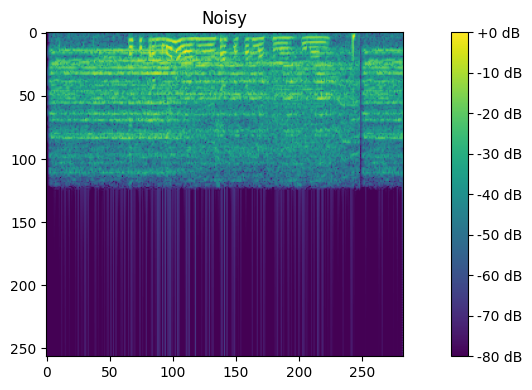

In [ ]:
# Model testing
audio_files = '/run/media/svyatoslav/Files/Projects/Speech Denoising with ITMO/speech_denosing/2_example_noisy.wav'

generator = FeatureExtractor()
x = generator.start_preprocess(audio_files)

result = model.predict(x)

In [ ]:
class AudioRestorer:

    def revert_features_to_audio(self, features, phase, mean, std):
        """
        Function for scaling the outpus back to the original range
        :param features: outputs from neural network in numpy array
        :param phase: saved at first features preparation stage phase value
        :param mean: saved at first features preparation stage mean value
        :param std: saved at first features preparation stage std value
        :return: numpy array with restored audio
        """
        phase = np.transpose(phase, (1, 0))
        features = np.squeeze(features)

        if mean and std:
            features = std * features + mean

        features = features * np.exp(1j * phase)
        features = np.transpose(features, (1, 0))

        self.show_spectrogram(features, "Denoised")
        restored = self._restore_audio(features)

        return restored

    def _restore_audio(self, stft_features):
        """
        Function for restoring audio from stft spectrogram
        :param stft_features: outputs from neural network in numpy array
        :return: numpy array with restored audio
        """
        return librosa.istft(stft_features, win_length=WINDOW_LENGTH, hop_length=OVERLAP, window='hamming', center=True)

    def write_audio(self, denoised, filename):
        """
        Write audiofile
        :param denoised: numpy array with restored audio
        :param filename: str filename
        :return: path to file in str
        """
        path = f'audios/{filename}.wav'
        sf.write(path, denoised, SAMPLE_RATE)
        return path

    def show_spectrogram(self, spectrogram, title):
        result = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max)
        plt.figure(figsize=(10, 4))
        plt.imshow(result)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()


In [ ]:
denoised = AudioRestorer().revert_features_to_audio(
    result, generator.audio_phase, generator.mean, generator.std)
print("Min:", np.min(denoised), "Max:", np.max(denoised))
ipd.Audio(data=denoised, rate=SAMPLE_RATE)  # show wav file


In [ ]:
# noisy_audio, sr = read_audio('noisy_file_example.wav', feature_sample)
# clean_audio, sr = read_audio('clean_file_example.wav', feature_sample)
# # denoised, sr = read_audio('denoised_file_example.wav', feature_sample)

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

# ax1.plot(clean_audio)
# ax1.set_title("Clean & Denoised Audio")

# ax2.plot(denoised)


In [ ]:
# import soundfile as sf
# #
# sf.write('denoised_file_example.wav',denoised, feature_sample)


In [ ]:
#!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip


In [ ]:
# from pysepm import stoi, pesq
# import mir_eval

# # load reference and denoised signal
# denoised = np.concatenate((denoised, np.zeros(clean_audio.size - denoised.size)), axis=0)
# noisy = np.concatenate((noisy_audio, np.zeros(clean_audio.size - noisy_audio.size)), axis=0)

# score = pesq(noisy, denoised, int(feature_sample))
# score1 = pesq(clean_audio, noisy, int(feature_sample))

# st = stoi(noisy, denoised, int(feature_sample), extended=False)
# st1 = stoi(clean_audio, noisy, int(feature_sample), extended=False)

# sdr, _,_,_= mir_eval.separation.bss_eval_sources(np.asarray([noisy_audio]), np.asarray([denoised]))

# print("pesq score: ",score)
# print("pesq score 1: ",score1)
# print("stoi value: ", st)
# print("stoi value 1: ", st1)
# print("sdr value:", sdr[0])
